# Project 1: AirBnB Dataset from Seattle

The focus in this project will be set to the host of an AirBnB accomodation.
The following questions will be adressed:
1. When is the most financially beneficial time to offer your apartment to a guest ?
2. What are some important AirBnb - host parameters you should set up in your host account and do they have an impact on the overall review score ?
3. Are there other important parameters that influence your review score ? In this example i analyzed the neighborhood your apartment is located and the number of amenities that come with your apartment. Do people care about neighborhood or the amenities they have during their stay ?

For the medium post i reduced my findings to:
- Best time to offer
- Question 2
- Impact of amenities

In [1]:
import pandas as pd
import numpy as np
import calendar
import re
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import seaborn as sns

In [2]:
# Load the datasets-links from github
data_calendar = r'https://raw.githubusercontent.com/LtdDan82/Airbnb_seattle/master/data_seattle/calendar.csv'
data_listings = r'https://raw.githubusercontent.com/LtdDan82/Airbnb_seattle/master/data_seattle/listings.csv'
data_reviews = r'https://raw.githubusercontent.com/LtdDan82/Airbnb_seattle/master/data_seattle/reviews.csv'

In [3]:
# Define a function to load dataset into a pandas dataframe
def get_csv_from_git(path_to_git):
    df = pd.read_csv(path_to_git)
    
    return df

In [6]:
# 1st question: When is the most financially beneficial time tto offer your apartment to a guest ?
def get_avg_price_per_month():
    '''
    1st Question: When is the most financially beneficial time to offer your apartment to a guest ?
    - Loads dataset "calendar" from github and creates a dataframe
    - Data is cleansed and dates are converted from type(str) to datetime objects
    - Mean price value per month in the year 2016 is calculated
    - A bar plot is created vor visualization
    - Returns: top_months
    
    '''
    df_cal = get_csv_from_git(data_calendar)
  
    
    # 1. Data Preparation
    # Generate datetime object from date in df_cal
    df = df_cal.copy(deep = True)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
    # Check for any 'NaT' values:
    if not np.count_nonzero(df['date']) == len(df['date']):
        print('Found NaT values')
    # Get month and year as separate columns:
    df['month'] = [x.month for x in df['date']]
    df['year'] = [x.year for x in df['date']]
    #Rename month to Jan, Feb, ...
    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    # price is currently a string --> want a int/float for aggregation functions
    # first get only the numeric part of the string
    df['price_in_$'] = df['price'].str.extract('(\d+)')
    df['price_in_$'] = pd.to_numeric(df['price_in_$'], errors='coerce')
    # We only want to consider the year 2016 , so drop year 2017
    df = df[df['year'] == 2016]
    final_df = df[['listing_id', 'price_in_$', 'month']]
    # Drop rows with no price
    final_df = final_df.dropna(subset = ['price_in_$'], axis = 0)
    
    # 2.  Modeling (here just some statistics)
    # Get mean prices per month and sort by month
    monthly_mean = final_df.groupby('month')['price_in_$'].mean()
    
    # 3. Evaluation
    # Graphical evaluation for communicating with stakeholders 
    cats = ['Jan', 'Feb', 'Mar',
            'Apr','May','Jun',
            'Jul', 'Aug','Sep',
            'Oct', 'Nov', 'Dec']
    
    monthly_mean.index = pd.CategoricalIndex(monthly_mean.index,
                                             categories=cats, ordered=True)
    monthly_mean = monthly_mean.sort_index()
    plt.figure()
    ax = monthly_mean.plot.bar(title = 'Seattle Average Airbnb prices per month (2016)',
                               color = 'gray')
    ax.set_ylabel('Price in $')
    #plt.savefig('cost_per_month.png') #only used for locally extracting the image
    # Calculate top three travelling months
    top_months = monthly_mean.nlargest(3).index.tolist()
    return top_months
    

The top three months to maximize profit for your accomodation in Seattle are Jul, Aug and Jun.


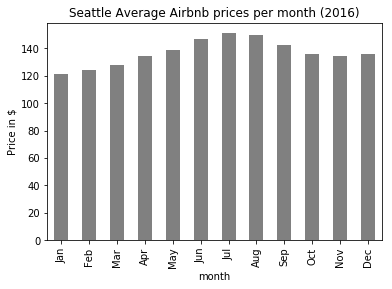

In [7]:
# Answer to question #1    
top_months = get_avg_price_per_month()
print('The top three months to maximize profit' + 
          ' for your accomodation in Seattle are %s, %s and %s.'
          % (top_months[0], top_months[1], top_months[2]))    

In [9]:
# 2nd QUestion: What are some important AirBnb - Host Parameters you should set up in your host account?
# Do they have an impact on the overall review score ?
def get_host_review_corr():
    df_listings = get_csv_from_git(data_listings)     
    # 1./2. Business/Data Understanding
    '''
    2nd Question: Is there a correlation between the host profile and the review_scores_rating on AirBnB ?
    - Loads dataset "listings" from github and creates a dataframe
    - Prepares the data (removing NaN from target value: review_scores, maps boolean values, ...)
    - Visualizes the correlation with review_scores_rating
    - Visualizes the difference in mean review scores for the top 2 features
    '''
    
    # All columns which you can influence easily by yourself when making an AirBnB-host account should partly influence your review score
    df = df_listings.copy(deep = True)
    host_info_cols = ['host_response_time',
                      'host_response_rate', 
                      'host_is_superhost', 
                      'host_has_profile_pic',
                      'host_about',                     
                      'review_scores_rating']
    
    
    df = df[host_info_cols]
    # 1. Data Preparation
    # 1.1 General
    #Remove rows from data where response value = NaN
    df = df.dropna(subset = ['review_scores_rating'], axis = 0)
    # 1.2 Host Response Rate
    # Transform the host_response_rate column from precentage of type "str" into decimals from 0 ... 1
    df['host_response_rate'] = df['host_response_rate'].str.extract('(\d+)')
    # Insert "0" for NaN values in column 'host_response_rate',
    # I assume that NaN means that the host never responded.
    # This information should not be lost
    df['host_response_rate'].fillna(value = str("0"), inplace = True)
    # Convert type "str" to decimals 0 ... 1
    df['host_response_rate'] = df['host_response_rate'].astype(float)/100
    # 1.3 Superhost and has_pic
    # Map t/f values in is_superhost and has_pic column to Boolean True and False
    d = {'t': True, 'f': False}
    convert_cols = ['host_is_superhost', 'host_has_profile_pic']
    df[convert_cols] = df[convert_cols].apply(lambda x: x.map(d))
    #3.4 host_about, True when host has a description, else False
    df['host_about'] = df['host_about'].notna()
        
    # 2. Evaluate - Check the correlation
    plt.figure()    
    sns.heatmap(df.corr(), annot = True, fmt = '.2f')
    #plt.savefig('host_para_correlation.png')
    
    # only used "host_is_superhost" and "host_about" as these show the highest correlations

    # get the correlation matrix values for review score rating
    rev_score_corr = df.corr()['review_scores_rating']
    # Find the top 2 in terms of correlation to review score rating
    top_2_corr = rev_score_corr.nlargest(4)
    top_2_corr.sort_values(ascending = False, inplace = True)
    top_1, top_2 = top_2_corr.index[[1,2]]
    # 3. Evaluate
    
    # Compare the mean values of 'review_scores_rating' for the top1 and top2
    top1_means = df.groupby(by=top_1)['review_scores_rating'].mean()
    top2_means = df.groupby(by=top_2)['review_scores_rating'].mean()

      
    # Plotting
    plt.figure()    
    title = 'Mean review scores for feature: ' + top_1
    ax1 = top1_means.plot.bar(title = title)
    ax1.set_ylim(bottom = 80, top = 100)
    ax1.set_ylabel('Review Score Rating')
    #plt.savefig('rev_scores_superhost.png')
    
    plt.figure()
    title = 'Mean review scores for feature: ' + top_2
    ax2 = top2_means.plot.bar(title = title)
    ax2.set_ylim(bottom = 80, top = 100)
    ax2.set_ylabel('Review Score Rating')
    #plt.savefig('rev_scores_host_about.png')
  
  
    return top_2_corr, top_1, top_2

Correlation with host_is_superhost: 0.24
Correlation with host_about: 0.07


The top 2 correlating "host parameters" are host_is_superhost and host_about
As a host you should become a superhost and write some short stuff about yourself, so that people get to know you


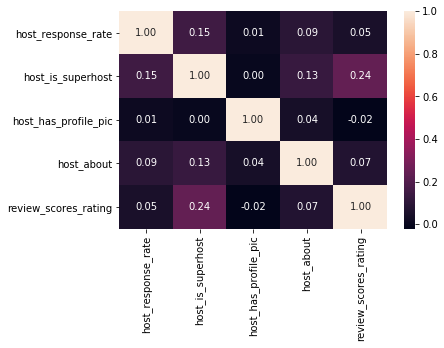

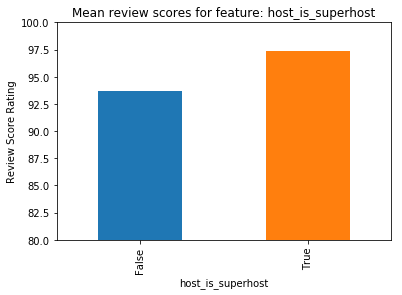

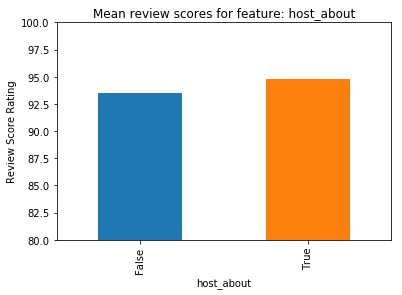

In [10]:
# Answer question 2
top_2_corr, top_1, top_2 = get_host_review_corr()

print('Correlation with %s: %.2f' % (top_1, round(top_2_corr[top_1], 2)))
print('Correlation with %s: %.2f' % (top_2, round(top_2_corr[top_2], 2)))

print('\n')
print('The top 2 correlating "host parameters" are %s and %s' % (top_1, top_2))
print('As a host you should become a superhost and write some short stuff about yourself, so that people get to know you')

In [11]:
# 3rd question: Are there other important parameters that influence your review score ? 
# In this example i analyzed the neighborhood your apartment is in and the number of amenities that comes with your apartment. 
# Do people care about neighborhood or the amenities they have during their stay ?

def additional_parameters():
    '''3rd Question: What are other important parameters that influence your review score ?
    - Reads in the dataset "Listings" and creates a pandas df
    - Checks the average review score for each neighbourhood + Visualization
    - Checks if the number of amenities in your apartment have a positive influence on the review score + Visualization
    - 
    '''
    
    
    
    df_listings = get_csv_from_git(data_listings)
    influences = ['neighbourhood_group_cleansed', 'amenities',
                  'accommodates', 'square_feet', # sqaure_feet per accomodate --> more space
                  'review_scores_rating']
    
    new_df = df_listings[influences]
    
    # 1. Data Preparation
    # As an example we check if the neighborhood plays a certain role and if the
    # number of amenities that the host offers can increase your review_score rating
    
    # 1.1 General
    #Remove rows from data where response value = NaN
    new_df = new_df.dropna(subset = ['review_scores_rating'], axis = 0)
    
    # 1.2 Amenities columns - Count the number of amenities
    # Clean the amenities column for further processing: Count the number of amenities
    new_df['amenities'] = new_df['amenities'].str.replace('{', '')
    new_df['amenities'] = new_df['amenities'].str.replace('}', '')
    new_df['amenities'] = new_df['amenities'].str.replace('"', '')
    #new_df['amenities'] = new_df['amenities'].str.replace('', [])
    
    # Transform to list of strings
    new_df['amenities'] = new_df['amenities'].apply(lambda x: x.split(","))
    # Insert length of list, except if the list has only the empty string: ''
    new_df['amenities'] = new_df['amenities'].apply(lambda x: len(x) if x != [''] else 0)
    
    # 1.3 What is the best neighborhood to have an apartment ?
    col = 'neighbourhood_group_cleansed'
    best_neighborhoods = new_df.groupby(col)['review_scores_rating'].mean()
    best_neighborhoods.rename(index={'Other neighborhoods':'Other',
                                       'University District': 'Univ. District'},
                                        inplace=True)
    
    
    plt.figure()
    title = 'Best Neighbourhoods by Review Score Rating'
    ax_nbh = best_neighborhoods.plot.bar(title = title, color = 'blue')
    ax_nbh.set_ylabel('Review Score Rating')
    ax_nbh.set_ylim(bottom = 85, top = 100)
    plt.xticks(rotation = 45, ha = 'right')
    
    #plt.savefig('neighbourhoods_rev_score.png')
    
    
    
    # 1.4 Does the number of amenities also influence your review score ?
    # For that we first need to find out the how large the sample size of the 'amenties' columns is
    count_amenities = new_df.groupby('amenities')['review_scores_rating'].count()
    
    # Evaluation / Visualization
    plt.figure()
    ax_amen_count = count_amenities.plot.bar(color = 'black')
    ax_amen_count.set_ylabel('Number of samples')
    #plt.savefig('sample_size_amenities.png')
    # We can clearly see that the sample size of very few 
    # and very many amenities is rather low
    # Consequently we only take samples with a sample size larger than 50
    # into account in order to answer the question
    filter_counts = count_amenities[count_amenities > 50].index.tolist()
    filter_df = new_df[new_df['amenities'].isin(filter_counts)]
    min_amenities = filter_df.groupby('amenities')['review_scores_rating'].mean()
    
    plt.figure()
    ax_amen = min_amenities.plot(title = 'Influence of amenities on review_score_rating')
    ax_amen.set_ylabel('Review Score Rating')
    ax_amen.set_xlabel('number of amenities')
    #plt.savefig('numberAmenities_vs_rev_score.png')
    
    return best_neighborhoods, min_amenities

From the neighborhood plot we can see that Univ. District seems not that satisfying for people.
From the last plot we can see that more amenities seem to have a positive influence on the review score


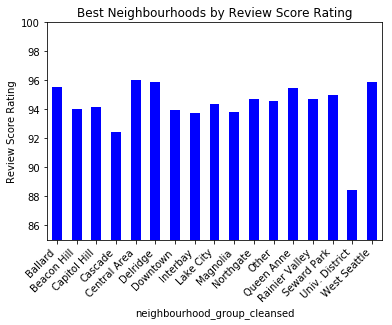

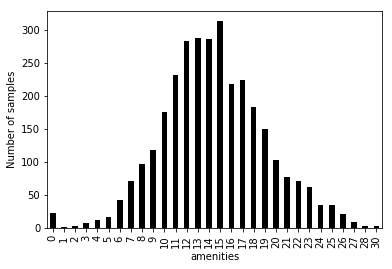

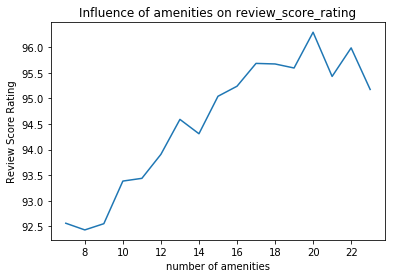

In [12]:
# Answer Question 3:

best_neighborhoods, min_amenities = additional_parameters()
print('From the neighborhood plot we can see that %s seems not that satisfying for people.' %(best_neighborhoods.nsmallest().index[0]))
print('From the last plot we can see that more amenities seem to have a positive influence on the review score')  